In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qtpyt.tools import expand_coupling
from ase.build import nanotube
from ase.neighborlist import NeighborList
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.parallel.egrid import GridDesc

In [3]:
def build_device_structure(n=6, m=0, N_L=3, N_M=4, N_R=3, bond=1.42, direction='x', tag_regions=True):
    """
    Build a CNT device using ASE nanotube with clear region tagging.

    Args:
        n, m: Chiral indices.
        N_L, N_M, N_R: Unit cells in left, middle, right.
        bond: C–C bond length.
        direction: Axis of tube ('x', 'y', or 'z').
        tag_regions: Whether to tag atoms by region (L=1, M=2, R=3).

    Returns:
        ase.Atoms with 'region' tags if enabled.
    """
    total_cells = N_L + N_M + N_R
    atoms = nanotube(n=n, m=m, length=total_cells, bond=bond, verbose=False)


    if direction == 'x':
        atoms.rotate('z', 'x', rotate_cell=True, center='COP')
        axis = 0
    elif direction == 'y':
        atoms.rotate('z', 'y', rotate_cell=True, center='COP')
        axis = 1
    elif direction == 'z':
        axis = 2
    else:
        raise ValueError("Direction must be 'x', 'y', or 'z'")


    positions = atoms.get_positions()
    coord = positions[:, axis]
    x_min, x_max = coord.min(), coord.max()
    total_len = x_max - x_min
    uc_len = total_len / total_cells


    x_L = x_min + N_L * uc_len
    x_M = x_L + N_M * uc_len

    if tag_regions:
        regions = []
        for x in coord:
            if x < x_L:
                regions.append(1)
            elif x < x_M:
                regions.append(2)
            else:
                regions.append(3)
        atoms.set_array('region', np.array(regions, dtype=int))

    atoms.set_pbc((1, 0, 0))
    return atoms

def apply_strain(atoms, strain_percent, axis=0, copy=True):
    """
    Apply uniaxial strain only to region 2 (middle) of the CNT structure,
    anchoring the left boundary and shifting region 3 to preserve bond lengths.

    Parameters
    ----------
    atoms : ase.Atoms
        Atomic structure with a 'region' array.
    strain_percent : float
        Strain percentage to apply to region 2.
    axis : int
        Axis along which to apply strain (default: 0 for x-axis).
    copy : bool
        If True (default), operates on a copy of `atoms`. If False, modifies `atoms` in-place.

    Returns
    -------
    ase.Atoms
        Strained ASE Atoms object.

    Notes
    -----
    Region 2 is stretched from its left boundary.
    Region 3 is rigidly shifted to maintain M–R bond lengths.
    Region 1 is left unmodified.
    """
    if copy:
        atoms = atoms.copy()

    if 'region' not in atoms.arrays:
        raise ValueError("Atoms object must have 'region' array to apply region-specific strain.")

    positions = atoms.get_positions()
    regions = atoms.get_array('region')

    strain = 1 + strain_percent / 100.0
    coord = positions[:, axis]
    mask_M = regions == 2
    mask_R = regions == 3


    x_M_min = coord[mask_M].min()
    x_M_max = coord[mask_M].max()
    original_length = x_M_max - x_M_min


    strained_positions = positions.copy()
    strained_positions[mask_M, axis] = x_M_min + strain * (positions[mask_M, axis] - x_M_min)


    delta = (strain - 1.0) * original_length
    strained_positions[mask_R, axis] += delta

    atoms.set_positions(strained_positions)
    return atoms

def build_real_space_device_hamiltonian(
    atoms,
    pairs,
    bond=1.42,
    q_pi=3.1451,
    q_sigma=7.428,
    V_pi=-2.7,
    V_sigma=0.48,
    angle_dependence=False,
    angles=None,
    degrees=True
):
    """
    Construct real-space Hamiltonian for a CNT device using known neighbor pairs.

    Parameters
    ----------
    atoms : ase.Atoms
        CNT device structure.
    pairs : list of tuples
        Precomputed nearest-neighbor pairs.
    bond : float
        Ideal bond length.
    beta : float
        Decay factor for hopping integral.
    t0 : float
        Hopping at ideal bond length.
    angle_dependence : bool
        Whether to include cos(theta) dependence based on precomputed angles.
    angles : list of float, optional
        List of angles for each pair in `pairs` (in degrees by default).
    degrees : bool
        Whether the provided angles are in degrees (default: True).

    Returns
    -------
    H : np.ndarray
        Hamiltonian matrix (N_atoms x N_atoms).
    """
    N_atoms = len(atoms)
    positions = atoms.get_positions()
    cell = atoms.get_cell()
    H = np.zeros((N_atoms, N_atoms), dtype=float)

    if angle_dependence and angles is None:
        raise ValueError("angles must be provided when angle_dependence=True")

    for idx, (i, j, offset) in enumerate(pairs):
        ri = positions[i]
        rj = positions[j] + np.dot(offset, cell)
        dist = np.linalg.norm(ri - rj)

        if angle_dependence:
            angle = angles[idx]
            if degrees:
                cos_theta = np.cos(np.radians(angle))
            else:
                cos_theta = np.cos(angle)
        else:
            cos_theta = 1.0

        hopping = V_pi * cos_theta * np.exp(-q_pi * (dist / bond - 1))

        H[i, j] = hopping
        H[j, i] = hopping

    return H

def get_nearest_neighbor_pairs(atoms, neighbor_cutoff=1.42, bond=1.42, atol=0.1):
    """
    Compute nearest-neighbor atom pairs using a distance cutoff and bond tolerance.

    Args:
        atoms (ase.Atoms): The atomic structure.
        neighbor_cutoff (float): Distance threshold for neighbors.
        bond (float): Ideal bond length.
        atol (float): Absolute tolerance for bond length deviation.

    Returns:
        List[Tuple[int, int, Tuple[int, int, int]]]: Valid neighbor pairs and cell offsets.
    """
    N = len(atoms)
    cutoffs = [neighbor_cutoff] * N
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    pairs = set()
    for i in range(N):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j > i:
                ri = positions[i]
                rj = positions[j] + np.dot(offset, cell)
                dist = np.linalg.norm(ri - rj)
                if np.abs(dist - bond) <= atol:
                    pairs.add((i, j, tuple(offset)))
    return list(pairs)

In [4]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
eta = 1e-5
first_neighbor_hopping = -2.7  # eV
q_pi = 0.0
neighbor_cutoff = 1.42  # Å for nearest neighbors
d0 = bond
energies = np.linspace(-3, 3, 100)
self_energy = np.load('lead_self_energy.npy',allow_pickle=True)

In [5]:
device = build_device_structure(n=6, m=0, N_L=1, N_M=4, N_R=1, direction='x')
pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)


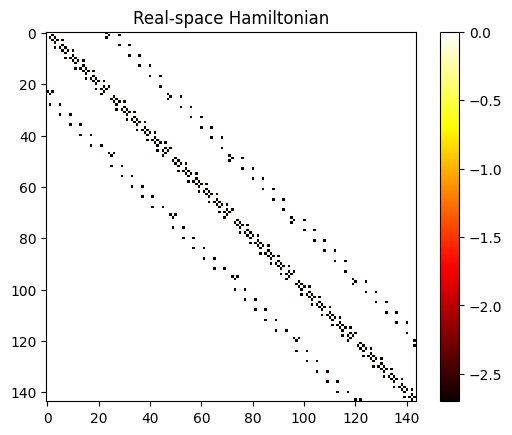

In [6]:
H_device= build_real_space_device_hamiltonian(device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping)
S_device = np.eye(H_device.shape[0])
plt.imshow(H_device, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Real-space Hamiltonian')
plt.show()


In [7]:
expand_coupling(self_energy[0], len(H_device[0]))
expand_coupling(self_energy[1], len(H_device[0]), id='right')

# slice(None) means that we've already expanded the leads to the scattering region
gf = GreenFunction(H_device, S_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)

gd = GridDesc(energies, 1)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy, ferretti=False)

T = gd.gather_energies(T)

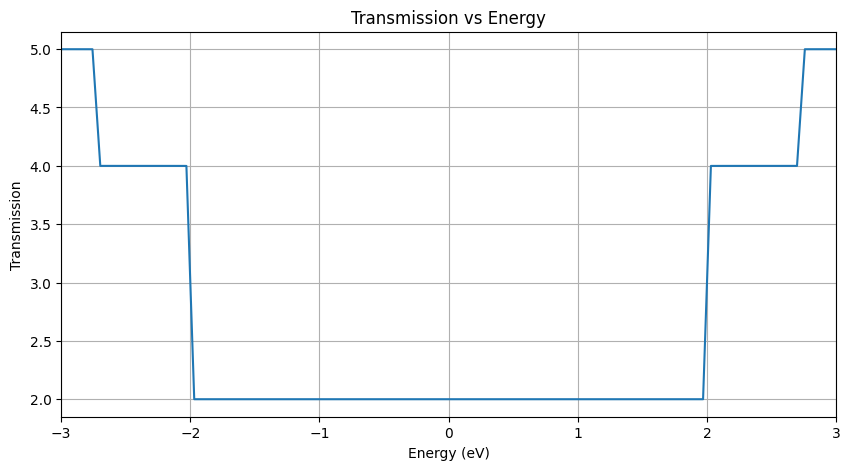

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(energies, T)
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.grid()
plt.show()


### Strained

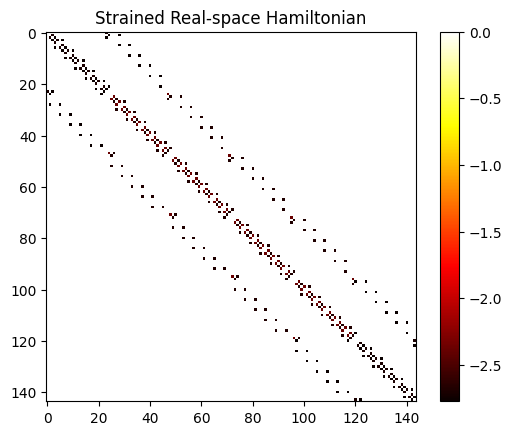

In [9]:
q_pi = 3.1451 # Value from WannierTools, https://pubs.acs.org/doi/10.1021/acs.nanolett.9b05117
strained_device = apply_strain(device, 4.0, axis=0)
H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping)
S_strained_device = np.eye(H_strained_device.shape[0])
plt.imshow(H_strained_device, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Strained Real-space Hamiltonian')
plt.show()

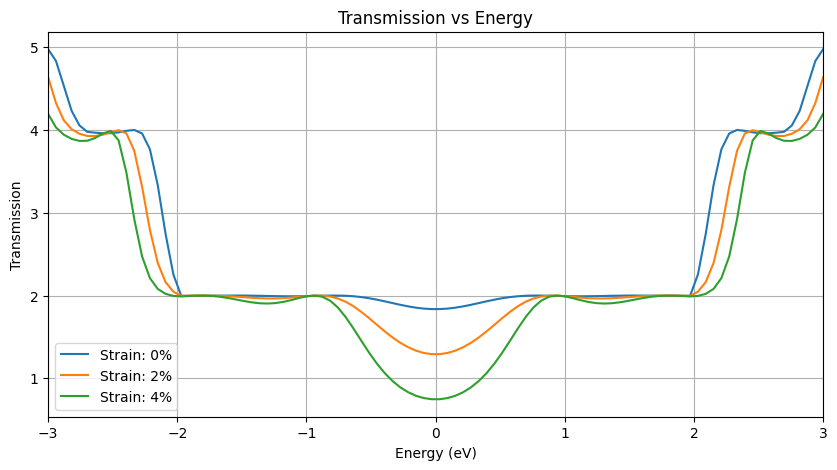

In [10]:
strain_percentages = np.array([0, 2, 4])
plt.figure(figsize=(10, 5))
for strain in strain_percentages:
    strained_device = apply_strain(device, strain, axis=0)
    H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping)
    S_strained_device = np.eye(H_strained_device.shape[0])

    gf = GreenFunction(H_strained_device, S_strained_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)

    gd = GridDesc(energies, 1)
    T = np.empty(gd.energies.size)

    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=False)

    T = gd.gather_energies(T)
    plt.plot(energies, T, label=f"Strain: {strain}%")
plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

### Increase number of unit cell that are strained

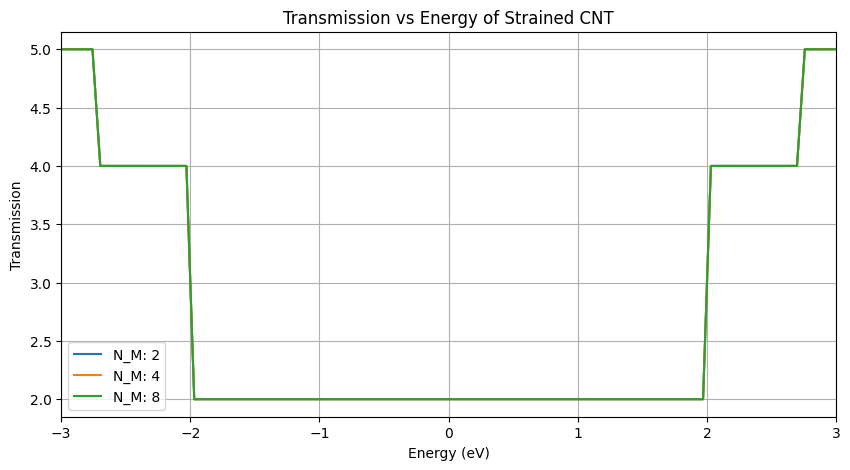

In [ ]:
N_Ms = [2, 4, 8]
strain = 4.0
plt.figure(figsize=(10, 5))
q_pi = 3.1451
for N_M in N_Ms:
    device = build_device_structure(n=6, m=0, N_L=1, N_M=N_M, N_R=1, direction='x')
    pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)

    strained_device = apply_strain(device, strain, axis=0)
    H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping)
    S_strained_device = np.eye(H_strained_device.shape[0])

    self_energy = np.load('lead_self_energy.npy',allow_pickle=True)
    expand_coupling(self_energy[0], len(H_strained_device[0]))
    expand_coupling(self_energy[1], len(H_strained_device[0]), id='right')

    gf = GreenFunction(H_strained_device, S_strained_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)


    gd = GridDesc(energies, 1)
    T = np.empty(gd.energies.size)

    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=False)

    T = gd.gather_energies(T)
    plt.plot(energies, T, label=f"N_M: {N_M}")

plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy of Strained CNT")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

### Increase the number of unstrained unit cells that serve as connection to the leads
- Fix the number of strained unit cells to 10 and the strain to 4 %

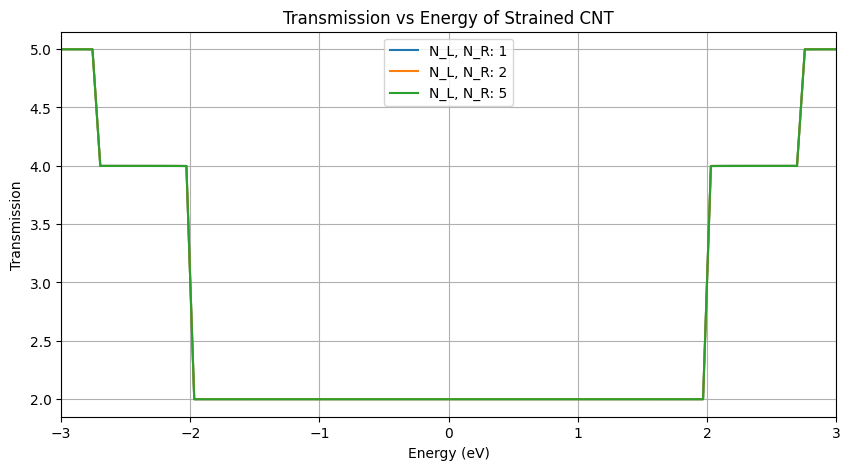

In [10]:
N_M = 10
N_Ls = [1, 2, 5]
strain = 4.0
plt.figure(figsize=(10, 5))

for N_L in N_Ls:
    device = build_device_structure(n=6, m=0, N_L=N_L, N_M=N_M, N_R=N_L, direction='x')
    pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)

    strained_device = apply_strain(device, strain, axis=0)
    H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping)
    S_strained_device = np.eye(H_strained_device.shape[0])

    self_energy = np.load('lead_self_energy.npy',allow_pickle=True)
    expand_coupling(self_energy[0], len(H_strained_device[0]))
    expand_coupling(self_energy[1], len(H_strained_device[0]), id='right')

    gf = GreenFunction(H_strained_device, S_strained_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)


    gd = GridDesc(energies, 1)
    T = np.empty(gd.energies.size)

    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy, ferretti=False)

    T = gd.gather_energies(T)
    plt.plot(energies, T, label=f"N_L, N_R: {N_L}")

plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy of Strained CNT")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

### Effect of curvature

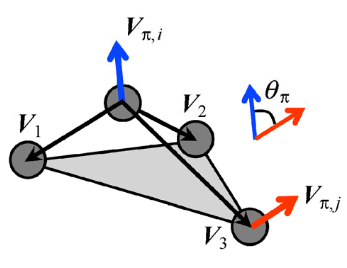

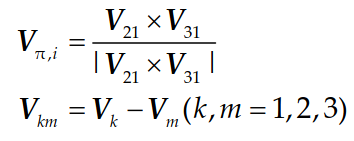

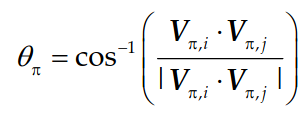

In [11]:
import numpy as np
from typing import List, Tuple
import plotly.graph_objects as go

def compute_pz_angles_plane_normals(
    atoms: 'ase.Atoms',
    pairs: List[Tuple[int, int, Tuple[int, int, int]]],
    degrees: bool = True
) -> Tuple[List[float], np.ndarray]:
    cell = atoms.get_cell()
    positions = atoms.get_positions()
    num_atoms = len(atoms)
    print(f"Number of atoms in extended device: {num_atoms}")
    centroid = np.mean(positions, axis=0)

    neighbor_dict = {i: [] for i in range(num_atoms)}
    for i, j, offset in pairs:
        if tuple(offset) == (0,0,0):
            neighbor_dict[i].append((j, offset))
            neighbor_dict[j].append((i, tuple(-np.array(offset))))

    pz_dirs = np.zeros((num_atoms, 3))
    for i in range(num_atoms):
        neighbors = neighbor_dict[i]
        if len(neighbors) < 3:
            print(f" Atom {i} has only {len(neighbors)} neighbors in the extended device.")
            continue

        V = []
        for j, offset in neighbors:
            V.append(positions[j] + np.dot(offset, cell) - positions[i])

        V1 = V[0]
        V2 = V[1]
        V3 = V[2]
        V21 = V2 - V1
        V31 = V3 - V1
        cross = np.cross(V21, V31)
        norm = np.linalg.norm(cross)
        if norm > 0:
            normal = cross / norm
            radial = positions[i].copy() - centroid
            radial[0] = 0.0
            if np.dot(normal, radial) < 0:
                normal = -normal
            pz_dirs[i] = normal
        else:
            print(f" Atom {i} has collinear neighbors, cannot compute pz direction.")

    angles = []
    for i, j, _ in pairs:
        ni = pz_dirs[i]
        nj = pz_dirs[j]
        dot = np.clip(np.dot(ni, nj), -1.0, 1.0)
        angle = np.arccos(dot)
        if degrees:
            angle = np.degrees(angle)
        angles.append(angle)

    return angles, pz_dirs

def compute_pz_dirs_and_angles(
    n: int,
    m: int,
    N_L: int,
    N_M: int,
    N_R: int,
    bond: float,
    direction: str,
    neighbor_cutoff: float,
    pairs_original: List[Tuple[int, int, Tuple[int, int, int]]],
    degrees: bool = True
) -> Tuple[List[float], np.ndarray]:
    device_extended = build_device_structure(n=n, m=m, N_L=N_L+1, N_M=N_M, N_R=N_R+1, bond=bond, direction=direction)
    pairs_extended = get_nearest_neighbor_pairs(device_extended, neighbor_cutoff=neighbor_cutoff)
    angles_ext, pz_dirs_ext = compute_pz_angles_plane_normals(device_extended, pairs_extended, degrees=degrees)

    n_atoms_unit = build_device_structure(n=n, m=m, N_L=0, N_M=1, N_R=0, bond=bond, direction=direction).get_positions().shape[0]
    start_idx = (N_L ) * n_atoms_unit
    end_idx = start_idx + (N_L + N_M + N_R ) * n_atoms_unit
    pz_dirs = pz_dirs_ext[start_idx:end_idx]

    original_indices = set(range(start_idx, end_idx))
    pair_to_angle = {}
    for (i, j, _), angle in zip(pairs_extended, angles_ext):
        if i in original_indices and j in original_indices:
            pair_to_angle[(i - start_idx, j - start_idx)] = angle
            pair_to_angle[(j - start_idx, i - start_idx)] = angle

    angles = []
    for i, j, _ in pairs_original:
        angle = pair_to_angle.get((i, j))
        if angle is None:
            print(f" Warning: No angle found for pair ({i}, {j}), setting angle = 0.")
            angle = 0.0
        angles.append(angle)

    return angles, pz_dirs

def plot_pz_normals_plotly(atoms, pz_dirs, pairs, scale=0.5):
    positions = atoms.get_positions()
    pz_dirs = np.array(pz_dirs)


    atom_trace = go.Scatter3d(
        x=positions[:, 0],
        y=positions[:, 1],
        z=positions[:, 2],
        mode='markers',
        marker=dict(size=5, color='black'),
        showlegend=False
    )


    arrow_traces = []
    for pos, dir_vec in zip(positions, pz_dirs):
        arrow = go.Scatter3d(
            x=[pos[0], pos[0] + scale * dir_vec[0]],
            y=[pos[1], pos[1] + scale * dir_vec[1]],
            z=[pos[2], pos[2] + scale * dir_vec[2]],
            mode='lines',
            line=dict(color='red', width=3),
            showlegend=False
        )
        arrow_traces.append(arrow)


    bond_traces = []
    cell = atoms.get_cell()
    for i, j, offset in pairs:
        ri = positions[i]
        rj = positions[j] + np.dot(offset, cell)
        bond = go.Scatter3d(
            x=[ri[0], rj[0]],
            y=[ri[1], rj[1]],
            z=[ri[2], rj[2]],
            mode='lines',
            line=dict(color='gray', width=3),
            showlegend=False
        )
        bond_traces.append(bond)


    fig = go.Figure(data=[atom_trace] + arrow_traces + bond_traces)

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
        ),
        title='CNT Atoms, pz Orbitals, and Bonds',
        margin=dict(l=0, r=0, b=0, t=30),
        showlegend=False
    )

    fig.show()

Number of atoms in extended device: 144
 Atom 0 has only 1 neighbors in the extended device.
 Atom 4 has only 1 neighbors in the extended device.
 Atom 8 has only 1 neighbors in the extended device.
 Atom 12 has only 1 neighbors in the extended device.
 Atom 16 has only 1 neighbors in the extended device.
 Atom 20 has only 1 neighbors in the extended device.
 Atom 121 has only 1 neighbors in the extended device.
 Atom 125 has only 1 neighbors in the extended device.
 Atom 129 has only 1 neighbors in the extended device.
 Atom 133 has only 1 neighbors in the extended device.
 Atom 137 has only 1 neighbors in the extended device.
 Atom 141 has only 1 neighbors in the extended device.


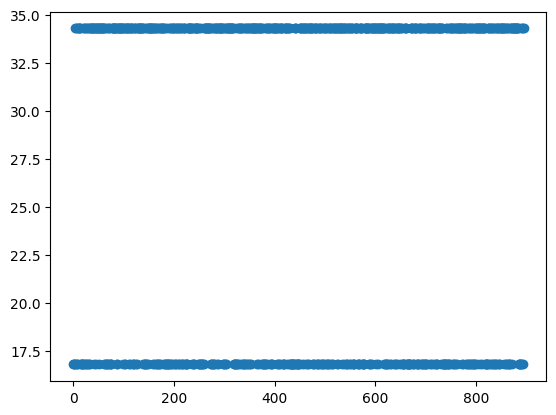

In [12]:
n,m = 6, 0
N_L, N_M, N_R = 1, 2, 1
bond = 1.42

device = build_device_structure(n=n, m=m, N_L=N_L, N_M=N_M, N_R=N_R, bond=bond, direction='x')
pairs = get_nearest_neighbor_pairs(
        device,
        neighbor_cutoff=1.43)


angles, pz_dirs = compute_pz_dirs_and_angles(
    n=n,
    m=m,
    N_L=N_L,
    N_M=N_M,
    N_R=N_R,
    bond=bond,
    direction='x',
    neighbor_cutoff=1.43,
    pairs_original=pairs,
)
plt.plot(angles, marker='o', linestyle='None')

In [36]:

plot_pz_normals_plotly(device, pz_dirs, pairs, scale=1.5)

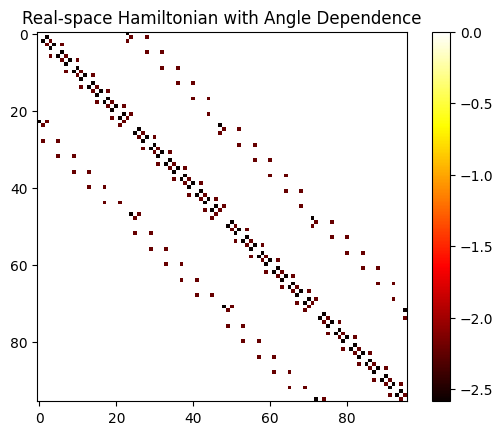

In [37]:
H_device_theta = build_real_space_device_hamiltonian(
    device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping, angle_dependence=True, angles=angles, degrees=True
)
plt.imshow(H_device_theta, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Real-space Hamiltonian with Angle Dependence')
plt.show()

Number of atoms in extended device: 336
 Atom 0 has only 1 neighbors in the extended device.
 Atom 4 has only 1 neighbors in the extended device.
 Atom 8 has only 1 neighbors in the extended device.
 Atom 12 has only 1 neighbors in the extended device.
 Atom 16 has only 1 neighbors in the extended device.
 Atom 20 has only 1 neighbors in the extended device.
 Atom 313 has only 1 neighbors in the extended device.
 Atom 317 has only 1 neighbors in the extended device.
 Atom 321 has only 1 neighbors in the extended device.
 Atom 325 has only 1 neighbors in the extended device.
 Atom 329 has only 1 neighbors in the extended device.
 Atom 333 has only 1 neighbors in the extended device.


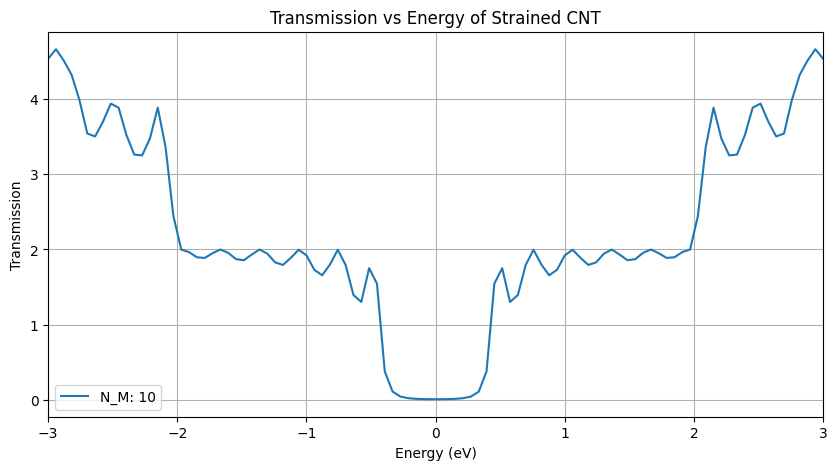

In [41]:
N_L, N_M, N_R = 1, 10, 1
n,m = 6, 0
bond = 1.42
strain = 4.0
plt.figure(figsize=(10, 5))

device = build_device_structure(n=n, m=m, N_L=N_L, N_M=N_M, N_R=N_R, direction='x')
pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)
strained_device = apply_strain(device, strain, axis=0)

angles, pz_dirs = compute_pz_dirs_and_angles(
n=n,
m=m,
N_L=N_L,
N_M=N_M,
N_R=N_R,
bond=bond,
direction='x',
neighbor_cutoff=neighbor_cutoff,
pairs_original=pairs,
)
# plt.plot(angles, marker='o', linestyle='None')
# plot_pz_normals_plotly(device, pz_dirs, pairs, scale=1.5)
H_strained_device = build_real_space_device_hamiltonian(strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping, angle_dependence=True, angles=angles, degrees=True)
S_strained_device = np.eye(H_strained_device.shape[0])

self_energy = np.load('lead_self_energy.npy',allow_pickle=True)
expand_coupling(self_energy[0], len(H_strained_device[0]))
expand_coupling(self_energy[1], len(H_strained_device[0]), id='right')

gf = GreenFunction(H_strained_device, S_strained_device, selfenergies=[(slice(None),self_energy[0]),(slice(None),self_energy[1])], eta=eta)


gd = GridDesc(energies, 1)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy, ferretti=False)

T = gd.gather_energies(T)
plt.plot(energies, T, label=f"N_M: {N_M}")

plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy of Strained CNT")
plt.xlim(-3, 3)
# plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

Number of atoms in extended device: 192
 Atom 0 has only 1 neighbors in the extended device.
 Atom 4 has only 1 neighbors in the extended device.
 Atom 8 has only 1 neighbors in the extended device.
 Atom 12 has only 1 neighbors in the extended device.
 Atom 16 has only 1 neighbors in the extended device.
 Atom 20 has only 1 neighbors in the extended device.
 Atom 169 has only 1 neighbors in the extended device.
 Atom 173 has only 1 neighbors in the extended device.
 Atom 177 has only 1 neighbors in the extended device.
 Atom 181 has only 1 neighbors in the extended device.
 Atom 185 has only 1 neighbors in the extended device.
 Atom 189 has only 1 neighbors in the extended device.


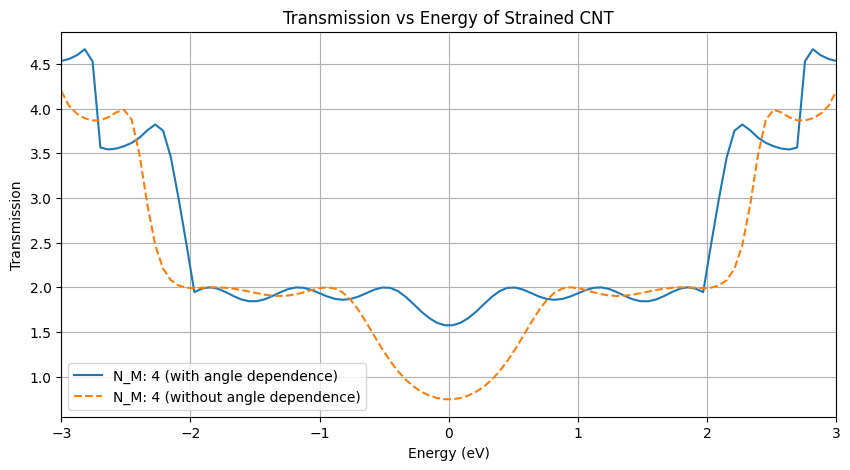

In [13]:
N_L, N_M, N_R = 1, 4, 1
plt.figure(figsize=(10, 5))
n,m = 6, 0
bond = 1.42
strain = 4.0

device = build_device_structure(n=n, m=m, N_L=N_L, N_M=N_M, N_R=N_R, direction='x')
pairs = get_nearest_neighbor_pairs(device, neighbor_cutoff=neighbor_cutoff)
strained_device = apply_strain(device, strain, axis=0)

angles, pz_dirs = compute_pz_dirs_and_angles(
    n=n,
    m=m,
    N_L=N_L,
    N_M=N_M,
    N_R=N_R,
    bond=bond,
    direction='x',
    neighbor_cutoff=neighbor_cutoff,
    pairs_original=pairs,
)

self_energy = np.load('lead_self_energy.npy', allow_pickle=True)
expand_coupling(self_energy[0], len(strained_device))
expand_coupling(self_energy[1], len(strained_device), id='right')

H_angle = build_real_space_device_hamiltonian(
    strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping,
    angle_dependence=True, angles=angles, degrees=True
)
H_no_angle = build_real_space_device_hamiltonian(
    strained_device, pairs, bond=bond, q_pi=q_pi, V_pi=first_neighbor_hopping,
    angle_dependence=False
)
S_strained_device = np.eye(H_angle.shape[0])

gf_angle = GreenFunction(H_angle, S_strained_device, selfenergies=[(slice(None), self_energy[0]), (slice(None), self_energy[1])], eta=eta)
T_angle = np.empty(energies.size)
for e, energy in enumerate(energies):
    T_angle[e] = gf_angle.get_transmission(energy, ferretti=False)

gf_no_angle = GreenFunction(H_no_angle, S_strained_device, selfenergies=[(slice(None), self_energy[0]), (slice(None), self_energy[1])], eta=eta)
T_no_angle = np.empty(energies.size)
for e, energy in enumerate(energies):
    T_no_angle[e] = gf_no_angle.get_transmission(energy, ferretti=False)

plt.plot(energies, T_angle, label=f"N_M: {N_M} (with angle dependence)")
plt.plot(energies, T_no_angle, label=f"N_M: {N_M} (without angle dependence)", linestyle='--')

plt.xlabel("Energy (eV)")
plt.ylabel("Transmission")
plt.title("Transmission vs Energy of Strained CNT")
plt.xlim(-3, 3)
plt.legend()
plt.grid()
plt.show()